In [1]:
__author__ = 'Elliot Simon'
__email__ = 'ellsim@dtu.dk'
__date__ = 'April 17, 2020'

# Configs

In [2]:
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import datetime
import time
import glob
from pathlib import Path
import os

In [3]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['figure.dpi'] = 70
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['xtick.major.pad'] = '8'
plt.rcParams['ytick.major.pad'] = '8'

In [4]:
%matplotlib inline

# File I/O

In [5]:
src = r"E:\TotalControl\Lillgrund\Full_SCADA_from_Vattenfall\2019_11"
out_folder = "E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\"

In [6]:
# Check number of files in directory
file_counts = [len(files) for r, d, files in os.walk(src)][1:]
print(set(file_counts))
if len(set(file_counts)) != 1:
    print('Error! There are missing source files! \nIssue dates = ')
    for i in set(file_counts):
        print(file_counts.index(i)+1)
else:
    print('Source files good!')

{336}
Source files good!


In [7]:
# Build list of files
all_files = glob.glob(src + "/*.csv", recursive=True)

In [8]:
all_files = []
for path in Path(src).rglob('*.csv'):
    all_files.append(str(path))

In [9]:
all_files[0:7]

['E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\2019_11\\SLG 2019-11-01\\SLGA01-ActivePower.csv',
 'E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\2019_11\\SLG 2019-11-01\\SLGA01-BladeAngleA.csv',
 'E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\2019_11\\SLG 2019-11-01\\SLGA01-BladeAngleB.csv',
 'E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\2019_11\\SLG 2019-11-01\\SLGA01-BladeAngleC.csv',
 'E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\2019_11\\SLG 2019-11-01\\SLGA01-NacelleDirection.csv',
 'E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\2019_11\\SLG 2019-11-01\\SLGA01-RotorRPM.csv',
 'E:\\TotalControl\\Lillgrund\\Full_SCADA_from_Vattenfall\\2019_11\\SLG 2019-11-01\\SLGA01-WindSpeed.csv']

In [10]:
channel_names = sorted(set([x.split('-')[-1].split('.')[0] for x in all_files]))
if len(channel_names) != 7:
       print('Something went wrong! There should be 7 repeating channel files')
else:
    print('Channels all good!')

Channels all good!


In [11]:
channel_names

['ActivePower',
 'BladeAngleA',
 'BladeAngleB',
 'BladeAngleC',
 'NacelleDirection',
 'RotorRPM',
 'WindSpeed']

In [12]:
turbine_names = sorted(set([x.split('-ActivePower.csv')[0].split('\\')[-1].split('SLG')[-1] for x in all_files]))[::7]
if len(turbine_names) != 48:
       print('Something went wrong! There should be 48 wind turbines')
else:
    print('Number of turbines is correct!')

Number of turbines is correct!


In [13]:
turbine_names

['A01',
 'A02',
 'A03',
 'A04',
 'A05',
 'A06',
 'A07',
 'B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'C01',
 'C02',
 'C03',
 'C04',
 'C05',
 'C06',
 'C07',
 'C08',
 'D01',
 'D02',
 'D03',
 'D04',
 'D06',
 'D07',
 'D08',
 'E01',
 'E02',
 'E03',
 'E04',
 'E06',
 'E07',
 'F02',
 'F03',
 'F04',
 'F05',
 'F06',
 'G02',
 'G03',
 'G04',
 'G05',
 'H02',
 'H03',
 'H04']

In [14]:
def format_dataframe(df):
    '''Function to process loaded data. Called from inside the main file I/O loop'''
    # Make sure no NaN values exist in data
    nulls = pd.isnull(df).any(1).nonzero()[0]
    if len(nulls) is not 0:
        print('Warning! There are some NaNs after loading data.\n Their indices are: ')
        print(nulls)
    # Convert datetime strings into DateTime objects and set as index
    df.set_index(df['dt'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f')), inplace=True)
    del df['dt']
    # Deal with any duplicated indices (happens sometimes)
    dupes_list = df.index.duplicated()
    dupe_indices = [i for i, x in enumerate(dupes_list) if x]
    if len(dupe_indices) is not 0:
        print('Warning! There are duplicated timestamps. Their integer indices are:')
        print(dupe_indices)
        print('..merging duplicates..')
        df = df.groupby(df.index).mean()
    # Resample into 2-second timeindex
    df = df.resample('2S').mean().interpolate('time')
    return df

In [15]:
%%time
# Load data in
# First dimension: Turbine
# Second dimension: Channel

all_data = []
for i, wtg in enumerate(turbine_names):
    print('Processing turbine {0} ({1} of {2})'.format(wtg, i+1, len(turbine_names)))
    turbine_file_list = []
    # Make a list of all files matching the turbine name
    [turbine_file_list.append(i) for i, s in enumerate(all_files) if wtg in s]
    # Make a 2D array where first dimension is day (e.g. 31) and second dimension is channels (i.e. 7)
    turbine_file_array = np.array(turbine_file_list).reshape(int(len(turbine_file_list)/len(channel_names)), len(channel_names))
    # Now go deeper by channel
    result = []
    for channel_num in range(0,len(channel_names)):
        channel = channel_names[channel_num]
        channel_file_list = turbine_file_array[:, channel_num].tolist()
        #print(channel_file_list)
        files = [all_files[i] for i in channel_file_list]
        #print(files)
        df = pd.concat((pd.read_csv(f, sep=',', header=None) for f in files))
        df.rename(columns={0:'dt', 1:str(channel)}, inplace=True)
        df = format_dataframe(df)
        result.append(df)
    all_data.append(result)

Processing turbine A01 (1 of 48)
Warning! There are duplicated timestamps. Their integer indices are:
[12441, 12442, 32777, 50252, 50253, 57685, 70279, 70280, 90592, 107842, 124735, 124736, 144143, 144144, 160496, 160497, 178735, 178736, 198616, 218309, 236561, 255609, 274398, 274399, 294439, 314553, 333947, 353112, 353113, 356829, 372542, 377298, 392474, 392708, 392709, 394407, 413417, 413418, 434251, 434252, 437088, 437101, 453462, 475380]
..merging duplicates..
Warning! There are duplicated timestamps. Their integer indices are:
[12829, 12830, 33131, 51183, 51184, 58457, 70784, 70785, 91093, 109324, 127450, 127451, 146844, 146845, 165745, 165746, 183916, 183917, 203455, 203456, 223303, 241338, 260120, 279044, 279045, 298767, 318752, 337922, 356981, 356982, 360608, 376514, 381158, 395985, 396214, 396215, 397928, 417550, 417551, 438041, 438042, 440854, 440866, 457447, 479137]
..merging duplicates..
Processing turbine A02 (2 of 48)
Warning! There are duplicated timestamps. Their intege

Warning! There are duplicated timestamps. Their integer indices are:
[12848, 12849, 33004, 51277, 51278, 58673, 71028, 71029, 91265, 109666, 127785, 127786, 147129, 166094, 166095, 184641, 184642, 204309, 224149, 242282, 261056, 280017, 280018, 299720, 319674, 339025, 358284, 358285, 361907, 377758, 382457, 397338, 397568, 397569, 399259, 418891, 418892, 439610, 442485, 442498, 459263, 480839]
..merging duplicates..
Processing turbine B04 (11 of 48)
Warning! There are duplicated timestamps. Their integer indices are:
[13012, 13013, 33406, 51253, 51254, 58763, 71338, 71339, 91533, 107758, 126047, 126048, 145063, 162153, 162154, 180632, 180633, 200432, 220307, 238680, 257749, 276321, 276322, 296416, 316528, 335818, 355119, 355120, 358819, 374535, 379296, 394445, 394674, 394675, 396380, 415929, 415930, 436887, 439795, 439808, 456555, 478506]
..merging duplicates..
Warning! There are duplicated timestamps. Their integer indices are:
[12874, 12875, 33191, 33192, 51471, 51472, 58860, 71206, 

Processing turbine C05 (20 of 48)
Warning! There are duplicated timestamps. Their integer indices are:
[13048, 13049, 33498, 51004, 51005, 58563, 71122, 71123, 91376, 108860, 125258, 125259, 143725, 159763, 159764, 178284, 178285, 198172, 217915, 236281, 255002, 274026, 274027, 294031, 312957, 332047, 351269, 351270, 354991, 356291, 370645, 375364, 390550, 390783, 390784, 392463, 412386, 412387, 433513, 436429, 436441, 453225, 475187]
..merging duplicates..
Warning! There are duplicated timestamps. Their integer indices are:
[12787, 12788, 32926, 51161, 51162, 58553, 70855, 70856, 90886, 109019, 126856, 126857, 146146, 164738, 164739, 183128, 183129, 202673, 222401, 240519, 259267, 278199, 278200, 297982, 317682, 336852, 356029, 356030, 359653, 360925, 375400, 380034, 394919, 395151, 395152, 396798, 416314, 416315, 436986, 439837, 439850, 456580, 478094]
..merging duplicates..
Processing turbine C06 (21 of 48)
Warning! There are duplicated timestamps. Their integer indices are:
[12037,

Warning! There are duplicated timestamps. Their integer indices are:
[11724, 11725, 30444, 47999, 48000, 54963, 66383, 66384, 85081, 102465, 119662, 119663, 137554, 155052, 155053, 172728, 172729, 191210, 209927, 227251, 245125, 263092, 263093, 281314, 299582, 317900, 335932, 335933, 339294, 353973, 358273, 372046, 372228, 372229, 373774, 391767, 391768, 410998, 410999, 413693, 413703, 429496, 448821, 448822]
..merging duplicates..
Processing turbine D08 (30 of 48)
Warning! There are duplicated timestamps. Their integer indices are:
[12896, 12897, 33276, 50582, 50583, 58031, 70591, 70592, 90849, 107197, 122911, 122912, 141353, 157330, 157331, 175479, 175480, 195351, 214816, 233045, 252052, 270742, 270743, 290759, 309793, 329163, 348270, 348271, 351999, 367666, 372404, 387489, 387719, 387720, 389439, 409249, 409250, 430111, 432965, 432978, 449451, 471270]
..merging duplicates..
Warning! There are duplicated timestamps. Their integer indices are:
[12681, 12682, 32826, 50746, 50747, 58068

Processing turbine F04 (39 of 48)
Warning! There are duplicated timestamps. Their integer indices are:
[13012, 13013, 33403, 50886, 50887, 58398, 70959, 70960, 90746, 106518, 122798, 122799, 141764, 158070, 158071, 176526, 176527, 196455, 216236, 228761, 244104, 262824, 262825, 282953, 302862, 322207, 341598, 341599, 345318, 361075, 365790, 380989, 381222, 381223, 382932, 402702, 402703, 423728, 426644, 426657, 443391, 465320]
..merging duplicates..
Warning! There are duplicated timestamps. Their integer indices are:
[12901, 12902, 33216, 51443, 51444, 58857, 71239, 71240, 91541, 109879, 128074, 128075, 147550, 166512, 166513, 184941, 184942, 204572, 224524, 242648, 261495, 280584, 280585, 300372, 320527, 339806, 359155, 359156, 362823, 378755, 383406, 398369, 398599, 398600, 400295, 419977, 419978, 440791, 443679, 443691, 460384, 482089]
..merging duplicates..
Processing turbine F05 (40 of 48)
Warning! There are duplicated timestamps. Their integer indices are:
[12973, 12974, 33446, 5

Warning! There are duplicated timestamps. Their integer indices are:
[12792, 12793, 32956, 51073, 51074, 58341, 70692, 70693, 90982, 109100, 126963, 126964, 146367, 146368, 165209, 165210, 183326, 183327, 202846, 202847, 222629, 240509, 259257, 278087, 278088, 297720, 317660, 336748, 355975, 355976, 359556, 375414, 380052, 394776, 395005, 396666, 416329, 416330, 436893, 439729, 439741, 456245, 477756]
..merging duplicates..
Wall time: 2h 18min 50s


In [16]:
file_indices = list(np.diff(turbine_file_list))
print(set(file_indices))
print(file_indices)

{1, 330}
[1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1, 330, 1, 1, 1, 1, 1, 1]


# Data inspection

In [18]:
# Determine start, stop, and length of data timestamps
duration=[]
for i in range(0,len(all_data),1):
    for j in range(0,len(all_data[i]),1):
        #print(i,j)
        #print(all_data[i][j].index.to_series().diff().fillna(0).describe())
        #print(all_data[i][j].first_valid_index())
        #print(all_data[i][j].last_valid_index())
        dur = all_data[i][j].last_valid_index() - all_data[i][j].first_valid_index()
        #print(dur)
        duration.append(dur)

In [19]:
# Check if all elements in list are close (i.e. all Data has the same duration)
print('Minimum data duration: {}'.format(min(duration)))
print('Maximum data duration: {}'.format(max(duration)))

Minimum data duration: 29 days 12:01:38
Maximum data duration: 29 days 23:59:54


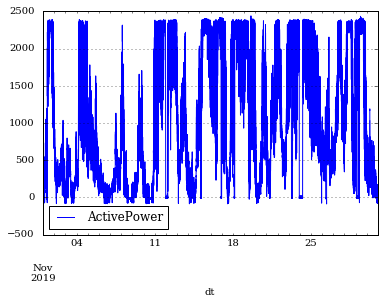

In [20]:
# Access DataFrames
# First dimension is turbine number, second dimension is channel number
f = plt.subplots
all_data[0][0].plot()

# Build DataSet

In [21]:
# Join channels together
# Done after processing separately because each channel has a different logging start time and sampling rate
# joined_data is a list of turbine indexed data with all channels
joined_data = []
for i, wtg_data_all_channels in enumerate(all_data):
    joined_data.append(pd.concat(wtg_data_all_channels, axis=1))

In [22]:
# Join turbines together on new dimension
ds = xr.concat([data.to_xarray() for data in joined_data], dim="Turbine")

In [23]:
# Label the Turbine dimension with turbine names
ds = ds.assign_coords(Turbine=turbine_names[0:len(joined_data)])

In [24]:
# Load in turbine geospatial coordinates
df_coords = pd.read_csv('lillgrund_wtg_positions.csv', sep=';')
df_coords.rename(columns={'Unnamed: 0':'Turbine'}, inplace=True)
df_coords.set_index(df_coords['Turbine'], inplace=True)
del df_coords['Turbine']

In [25]:
df_coords.head()

,Easting,Northing,Height,ZoneNum,ZoneLet,Latitude,Longitude
Turbine,,,,,,,
A01,361468.999969,6.154543e+06,3.5,33,U,55.517279,12.805881
A02,361203.000047,6.154244e+06,3.5,33,U,55.514518,12.801821
A03,360936.000006,6.153946e+06,3.5,33,U,55.511767,12.797745
A04,360669.999994,6.153648e+06,3.5,33,U,55.509015,12.793686
A05,360404.000091,6.153349e+06,3.5,33,U,55.506254,12.789628


In [26]:
# Make sure loaded turbine names are the same as determined from the data files
df_coords.index.tolist() == turbine_names

True

In [27]:
# Assign the coordinates to the DataSet
# We skip the Height column because that is related to the lidar
# UTM zone is put in as a dataset attribute
ds = ds.assign_coords(
    Easting=df_coords['Easting'][0:len(joined_data)],
    Northing=df_coords['Northing'][0:len(joined_data)],
    Latitude=df_coords['Latitude'][0:len(joined_data)],
    Longitude=df_coords['Longitude'][0:len(joined_data)]
)

In [28]:
# Assign dataset attributes/metadata

ds.attrs['Author'] = 'Elliot Simon'
ds.attrs['Contact'] = 'ellsim@dtu.dk'

ds.attrs['Wind_Farm'] = 'Lillgrund'
ds.attrs['Owner'] = 'Vattenfall'
ds.attrs['Wind_Farm_Type'] = 'Offshore'
ds.attrs['Wind_Farm_Capacity'] = '110 MW'
ds.attrs['Wind_Turbine_Manufacturer'] = 'Siemens'
ds.attrs['Wind_Turbine_Model'] = 'SWT-2.3-93'

ds.attrs['UTM_Zone'] = '33U'
ds.attrs['Time_Zone'] = 'TBD'

In [29]:
ds

<xarray.Dataset>
Dimensions:           (Turbine: 48, dt: 1295998)
Coordinates:
  * dt                (dt) datetime64[ns] 2019-10-31T23:00:02 ...
  * Turbine           (Turbine) object 'A01' 'A02' 'A03' 'A04' 'A05' 'A06' ...
    Easting           (Turbine) float64 3.615e+05 3.612e+05 3.609e+05 ...
    Latitude          (Turbine) float64 55.52 55.51 55.51 55.51 55.51 55.5 ...
    Longitude         (Turbine) float64 12.81 12.8 12.8 12.79 12.79 12.79 ...
    Northing          (Turbine) float64 6.155e+06 6.154e+06 6.154e+06 ...
Data variables:
    ActivePower       (Turbine, dt) float64 -11.0 -8.5 -6.0 8.333 22.67 37.0 ...
    BladeAngleA       (Turbine, dt) float64 nan nan nan nan nan nan nan nan ...
    BladeAngleB       (Turbine, dt) float64 nan nan nan nan nan nan nan nan ...
    BladeAngleC       (Turbine, dt) float64 nan nan nan nan nan -0.4 -0.3948 ...
    NacelleDirection  (Turbine, dt) float64 nan nan nan nan nan nan nan nan ...
    RotorRPM          (Turbine, dt) float64 nan nan n

In [30]:
%%time
# Save processed dataset to NetCDF file
filename = out_folder + 'TC_Lillgrund_SCADA_' + src.split('\\')[-1] + '.nc'
print('.. saving file {} ..'.format(filename))
ds.to_netcdf(filename)

.. saving file E:\TotalControl\Lillgrund\Full_SCADA_from_Vattenfall\TC_Lillgrund_SCADA_2019_11.nc ..
Wall time: 42.8 s


# Plotting

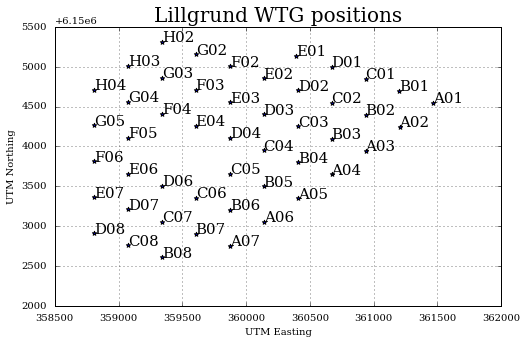

In [31]:
f = plt.figure(figsize=(8,5))
plt.title('Lillgrund WTG positions', fontsize=20)
plt.scatter(ds.coords['Easting'], ds.coords['Northing'], marker='*')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
for i,j in enumerate(ds.coords['Turbine'].values):
    plt.annotate(j, (ds.coords['Easting'][i], ds.coords['Northing'][i]), fontsize=15)

In [ ]:
# Make a power curve
#plt.hist2d(ds.sel(Turbine='B08')['WindSpeed'], ds.sel(Turbine='B08')['ActivePower'], bins=10)